In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

Dataset Display and Information

In [170]:
df = pd.read_csv("data/labelled_2021may-ip-10-100-1-105-dns.csv")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 2000)
print(df.head())

              Timestamp      SourceIP DestinationIP                     DnsQuery         DnsAnswer DnsAnswerTTL                DnsQueryNames DnsQueryClass DnsQueryType  NumberOfAnswers  DnsResponseCode  DnsOpCode         SensorId  sus  evil
0  2021-05-16T17:13:14Z   10.100.1.95    10.100.0.2  ssm.us-east-2.amazonaws.com               NaN          NaN  ssm.us-east-2.amazonaws.com        ['IN']        ['A']                0                0          0   ip-10-100-1-95    0     0
1  2021-05-16T17:13:14Z    10.100.0.2   10.100.1.95  ssm.us-east-2.amazonaws.com  ['52.95.19.240']       ['17']  ssm.us-east-2.amazonaws.com        ['IN']        ['A']                1                0          0   ip-10-100-1-95    0     0
2  2021-05-16T17:13:14Z   10.100.1.95    10.100.0.2  ssm.us-east-2.amazonaws.com               NaN          NaN  ssm.us-east-2.amazonaws.com        ['IN']     ['AAAA']                0                0          0   ip-10-100-1-95    0     0
3  2021-05-16T17:13:14Z    10.100.0.

In [125]:
print(df.shape)
print(df.describe())

(269, 10)
         DnsQuery  DnsQueryNames  DnsQueryClass  DnsQueryType  NumberOfAnswers  DnsResponseCode  DnsOpCode    SensorId         sus        evil
count  269.000000     269.000000     269.000000    269.000000       269.000000       269.000000      269.0  269.000000  269.000000  269.000000
mean    12.167286      12.167286       0.988848      0.672862         0.327138         0.066914        0.0    2.204461    0.078067    0.014870
std      2.563719       2.563719       0.105210      0.840247         0.817741         0.443845        0.0    1.460621    0.268777    0.121258
min      0.000000       0.000000       0.000000      0.000000         0.000000         0.000000        0.0    0.000000    0.000000    0.000000
25%     13.000000      13.000000       1.000000      0.000000         0.000000         0.000000        0.0    1.000000    0.000000    0.000000
50%     13.000000      13.000000       1.000000      1.000000         0.000000         0.000000        0.0    2.000000    0.000000  

Countplot of "sus" and "evil" values in the datset

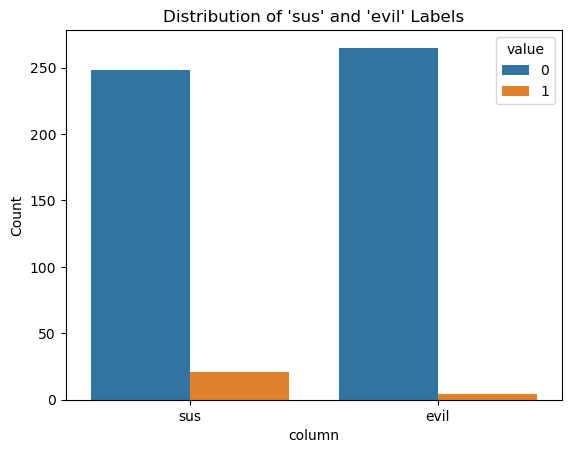

In [25]:
df_melted = df.melt(value_vars=['sus', 'evil'], 
                    var_name='column', 
                    value_name='value')
sns.countplot(x="column", hue="value", data=df_melted)
plt.title("Distribution of 'sus' and 'evil' Labels")
plt.ylabel("Count")
plt.show()

In [105]:
print(df["sus"].value_counts())
print(df["evil"].value_counts())

sus
0    248
1     21
Name: count, dtype: int64
evil
0    265
1      4
Name: count, dtype: int64


In [36]:
df.isna().sum().any

<bound method Series.any of Timestamp            0
SourceIP             0
DestinationIP        0
DnsQuery             0
DnsAnswer          204
DnsAnswerTTL       204
DnsQueryNames        0
DnsQueryClass        0
DnsQueryType         0
NumberOfAnswers      0
DnsResponseCode      0
DnsOpCode            0
SensorId             0
sus                  0
evil                 0
dtype: int64>

In [ ]:
drop_columns = ["SourceIP", "DestinationIP", "Timestamp", "DnsAnswer", "DnsAnswerTTL"]
df.drop(columns=drop_columns, errors = "ignore", inplace=True)
df.head()

,DnsQuery,DnsQueryNames,DnsQueryClass,DnsQueryType,NumberOfAnswers,DnsResponseCode,DnsOpCode,SensorId,sus,evil
0,ssm.us-east-2.amazonaws.com,ssm.us-east-2.amazonaws.com,['IN'],['A'],0,0,0,ip-10-100-1-95,0,0
1,ssm.us-east-2.amazonaws.com,ssm.us-east-2.amazonaws.com,['IN'],['A'],1,0,0,ip-10-100-1-95,0,0
2,ssm.us-east-2.amazonaws.com,ssm.us-east-2.amazonaws.com,['IN'],['AAAA'],0,0,0,ip-10-100-1-95,0,0
3,ssm.us-east-2.amazonaws.com,ssm.us-east-2.amazonaws.com,['IN'],['AAAA'],0,0,0,ip-10-100-1-95,0,0
4,ssm.us-east-2.amazonaws.com,ssm.us-east-2.amazonaws.com,['IN'],['A'],0,0,0,ip-10-100-1-186,0,0


In [44]:
#Convert categorical columns to numerical
non_numeric_cols = df.select_dtypes(include=['object']).columns
for col in non_numeric_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

In [45]:
df.head()

,DnsQuery,DnsQueryNames,DnsQueryClass,DnsQueryType,NumberOfAnswers,DnsResponseCode,DnsOpCode,SensorId,sus,evil
0,13,13,1,0,0,0,0,4,0,0
1,13,13,1,0,1,0,0,4,0,0
2,13,13,1,1,0,0,0,4,0,0
3,13,13,1,1,0,0,0,4,0,0
4,13,13,1,0,0,0,0,1,0,0


Check for duplicated columns

In [79]:
print(df.columns.duplicated())

[False False False False False False False False False False]


Create datasets, clean data, and fit to model

In [ ]:
#X is each column except sus and evil
#y ("sus") is the target variable
X = df[df.columns.difference(['sus', 'evil'])]
y = df["sus"]

#Scale features from -1 to 1 using MinMaxScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

#Split data using train test split w/ testing data being 20%
#Train model
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)   
model = RandomForestClassifier(random_state = 42, class_weight = "balanced",  max_depth=3, n_estimators=40)

(269, 8) (269,)


In [93]:
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, n_estimators=40,
                       random_state=42)

Display model's metrics of success based on testing set predictions

Accuracy: 96.2963% 

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        50
           1       0.67      1.00      0.80         4

    accuracy                           0.96        54
   macro avg       0.83      0.98      0.89        54
weighted avg       0.98      0.96      0.97        54



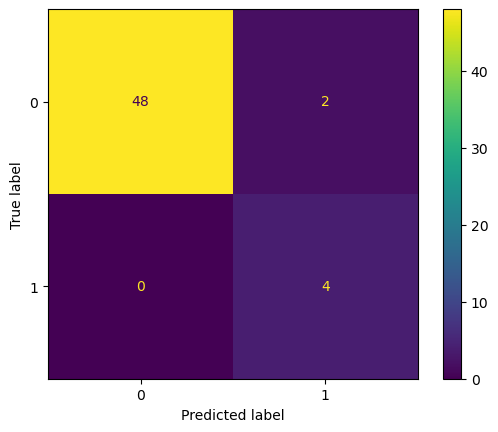

In [101]:
y_pred = model.predict(X_test)
print(f"Accuracy: {100*accuracy_score(y_test, y_pred):.4f}% \n")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
disp.plot()

# Apply same process to "evil" column

In [141]:
X_evil = df[df.columns.difference(['sus', 'evil'])]
y_evil = df["evil"]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_evil)

X_train_evil, X_test_evil, y_train_evil, y_test_evil = train_test_split(X_scaled, y_evil, test_size=0.20, random_state=42)   
model = RandomForestClassifier(random_state = 42, class_weight = "balanced",  max_depth=3, n_estimators=20)

In [142]:
model.fit(X_train_evil, y_train_evil)

RandomForestClassifier(class_weight='balanced', max_depth=3, n_estimators=20,
                       random_state=42)

Accuracy: 100.0000% 

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00         1

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



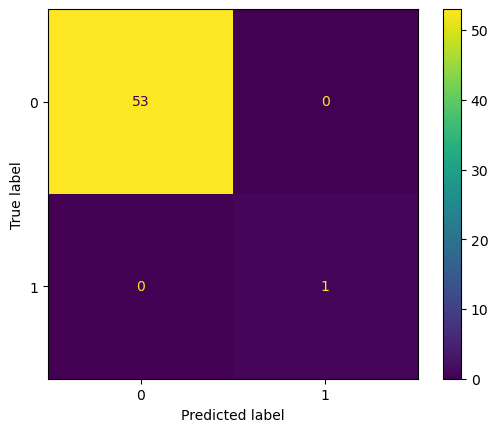

In [143]:
y_pred_evil = model.predict(X_test_evil)
print(f"Accuracy: {100*accuracy_score(y_test_evil, y_pred_evil):.4f}% \n")
print(f"Classification Report:\n{classification_report(y_test_evil, y_pred_evil)}")
disp = ConfusionMatrixDisplay(confusion_matrix(y_test_evil, y_pred_evil))
disp.plot()

Please note that the accuracy for testing sets is higher due to the relatively small amount of data present